### Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Upload Kaggle API json file

In [ ]:
from google.colab import files
files.upload()

### Download DeepFake *Dataset*

In [4]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces
!unzip 140k-real-and-fake-faces

Streaming output truncated to the last 5000 lines.
  inflating: real_vs_fake/real-vs-fake/valid/real/34832.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34836.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34839.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34847.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34848.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34852.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34861.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34864.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34868.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34877.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34883.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34887.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34891.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34894.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34904.jpg  
  inflating: real_v

### Import Libraries

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input, BatchNormalization, LeakyReLU
from keras.utils import Sequence, plot_model
from keras.applications import vgg16, resnet50, inception_v3
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

### Parameters

In [6]:
image_shape = (256, 256, 3)
batch_size = 16
epochs = 10

In [7]:
classes = ['fake', 'real']

In [8]:
train_path = "real_vs_fake/real-vs-fake/train"
val_path = "real_vs_fake/real-vs-fake/valid"
test_path = "real_vs_fake/real-vs-fake/test"

In [9]:
save_path = "drive/MyDrive/Colab Data/DeepFake Image"

### Data Generator

In [10]:
def customDataGen(data_path, preprocess_func=None, rescale=None, shuffle=True):
  image_gen = ImageDataGenerator(preprocessing_function=preprocess_func, rescale=rescale)

  data_gen = image_gen.flow_from_directory(
      directory = data_path,
      target_size = image_shape[:2],
      classes = classes,
      class_mode = 'binary',
      batch_size = batch_size,
      shuffle = shuffle
  )

  return data_gen

## VGG Model

### Prepare Data

In [ ]:
preprocess_func = vgg16.preprocess_input
train_gen = customDataGen(train_path, preprocess_func)
val_gen = customDataGen(val_path, preprocess_func)
test_gen = customDataGen(test_path, preprocess_func, shuffle=False)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


### Build Model

In [ ]:
vgg_layer = vgg16.VGG16(include_top=False, input_shape=(image_shape))
vgg_layer.trainable = False

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
flatten = Flatten()(vgg_layer.output)
output = Dense(1, activation='sigmoid', kernel_initializer='he_uniform')(flatten)
vgg_model = Model(inputs=vgg_layer.inputs, outputs=output)

vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

### Train Model

In [ ]:
history = vgg_model.fit(train_gen, validation_data=val_gen, epochs=epochs)

Epoch 1/10
6250/6250 [==============================] - 640s 101ms/step - loss: 3.5848 - accuracy: 0.8471 - val_loss: 4.6877 - val_accuracy: 0.8546
Epoch 2/10
6250/6250 [==============================] - 634s 102ms/step - loss: 3.0912 - accuracy: 0.8956 - val_loss: 3.9275 - val_accuracy: 0.8891
Epoch 3/10
6250/6250 [==============================] - 674s 108ms/step - loss: 2.7242 - accuracy: 0.9125 - val_loss: 4.3274 - val_accuracy: 0.8921
Epoch 4/10
6250/6250 [==============================] - 633s 101ms/step - loss: 2.4943 - accuracy: 0.9221 - val_loss: 5.0581 - val_accuracy: 0.8921
Epoch 5/10
6250/6250 [==============================] - 632s 101ms/step - loss: 2.3158 - accuracy: 0.9296 - val_loss: 6.0482 - val_accuracy: 0.8839
Epoch 6/10
6250/6250 [==============================] - 630s 101ms/step - loss: 2.1821 - accuracy: 0.9341 - val_loss: 5.5580 - val_accuracy: 0.8971
Epoch 7/10
6250/6250 [==============================] - 633s 101ms/step - loss: 2.0337 - accuracy: 0.9379 - val_

### Save Model

In [ ]:
vgg_model.save(os.path.join(save_path, "vgg/vgg_model.h5"))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Plots

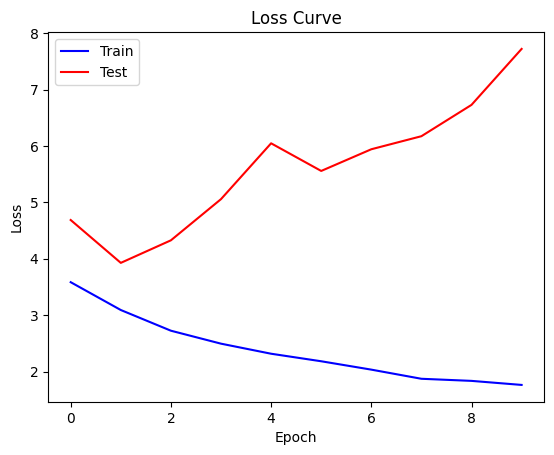

In [ ]:
plt.plot(history.history['loss'], color='blue', label='Train')
plt.plot(history.history['val_loss'], color='red', label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.savefig(os.path.join(save_path, "vgg/loss.png"))

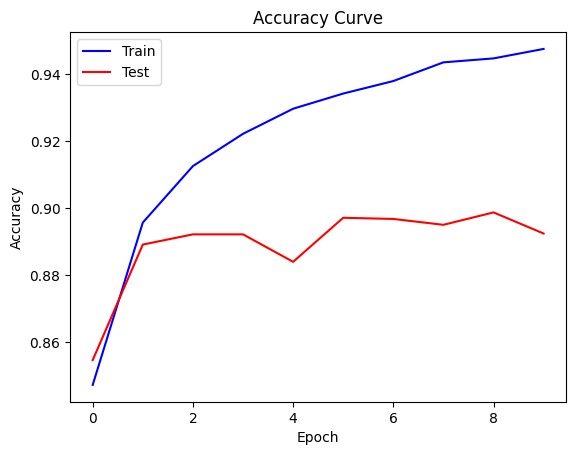

In [ ]:
plt.plot(history.history['accuracy'], color='blue', label='Train')
plt.plot(history.history['val_accuracy'], color='red', label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.savefig(os.path.join(save_path, "vgg/accuracy.png"))

### Evaluate Model

In [ ]:
vgg_model = load_model(os.path.join(save_path, "vgg/vgg_model.h5"))

In [ ]:
pred_value = vgg_model.predict(test_gen).flatten()

1250/1250 [==============================] - 115s 86ms/step


In [ ]:
pred_label = np.round(pred_value).astype(int)
true_label = test_gen.labels.flatten()

In [ ]:
print('Accuracy =', accuracy_score(true_label, pred_label))
print('Precision =', precision_score(true_label, pred_label))
print('Recall =', recall_score(true_label, pred_label))

Accuracy = 0.8929
Precision = 0.9384066056683776
Recall = 0.841


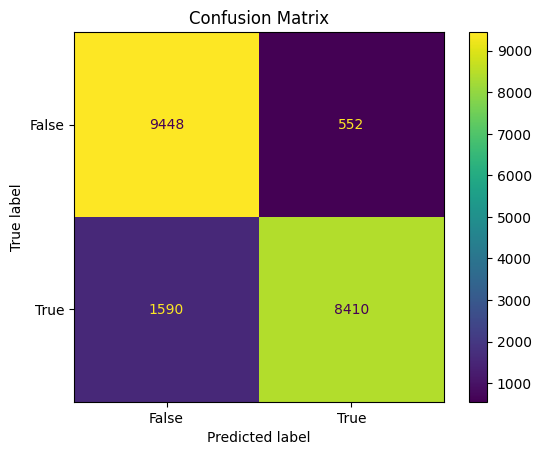

In [ ]:
cm = confusion_matrix(true_label, pred_label)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[False,True])
cm_display.plot()
plt.title('Confusion Matrix')
plt.savefig(os.path.join(save_path, "vgg/confusion matrix.png"))

## ResNet Model

### Prepare Data

In [ ]:
preprocess_func = resnet50.preprocess_input
train_gen = customDataGen(train_path, preprocess_func)
val_gen = customDataGen(val_path, preprocess_func)
test_gen = customDataGen(test_path, preprocess_func, shuffle=False)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


### Build Model

In [ ]:
resnet_layer = resnet50.ResNet50(include_top = False, input_shape=image_shape)
resnet_layer.trainable = False

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
flatten = Flatten()(resnet_layer.output)
output = Dense(1, activation='sigmoid', kernel_initializer='he_uniform')(flatten)
resnet_model = Model(inputs=resnet_layer.inputs, outputs=output)

resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

### Train Model

In [ ]:
history = resnet_model.fit(train_gen, validation_data=val_gen, epochs=epochs)

Epoch 1/10
6250/6250 [==============================] - 621s 98ms/step - loss: 1.5744 - accuracy: 0.9066 - val_loss: 1.0270 - val_accuracy: 0.9507
Epoch 2/10
6250/6250 [==============================] - 550s 88ms/step - loss: 0.9146 - accuracy: 0.9596 - val_loss: 1.0437 - val_accuracy: 0.9592
Epoch 3/10
6250/6250 [==============================] - 547s 88ms/step - loss: 0.6409 - accuracy: 0.9733 - val_loss: 1.5263 - val_accuracy: 0.9546
Epoch 4/10
6250/6250 [==============================] - 549s 88ms/step - loss: 0.5167 - accuracy: 0.9792 - val_loss: 1.3630 - val_accuracy: 0.9615
Epoch 5/10
6250/6250 [==============================] - 546s 87ms/step - loss: 0.4203 - accuracy: 0.9840 - val_loss: 1.2263 - val_accuracy: 0.9683
Epoch 6/10
6250/6250 [==============================] - 603s 96ms/step - loss: 0.3651 - accuracy: 0.9864 - val_loss: 1.3464 - val_accuracy: 0.9677
Epoch 7/10
6250/6250 [==============================] - 546s 87ms/step - loss: 0.3123 - accuracy: 0.9887 - val_loss: 1

### Save Model

In [ ]:
resnet_model.save(os.path.join(save_path, "resnet/resnet_model.h5"))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Plots

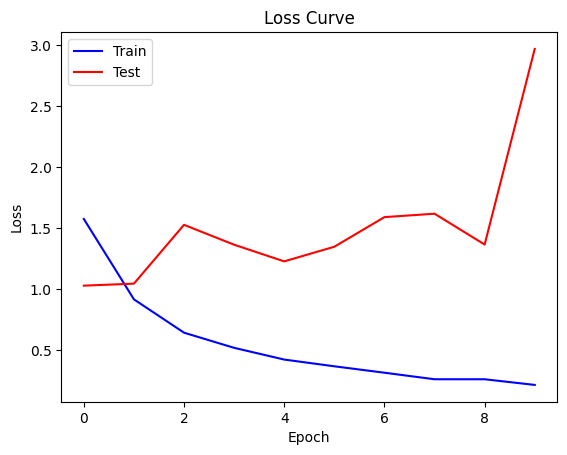

In [ ]:
plt.plot(history.history['loss'], color='blue', label='Train')
plt.plot(history.history['val_loss'], color='red', label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.savefig(os.path.join(save_path, "resnet/loss.png"))

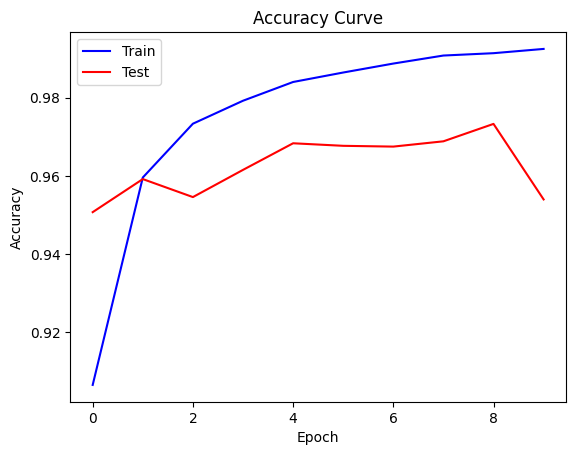

In [ ]:
plt.plot(history.history['accuracy'], color='blue', label='Train')
plt.plot(history.history['val_accuracy'], color='red', label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.savefig(os.path.join(save_path, "resnet/accuracy.png"))

### Evaluate Model

In [ ]:
pred_value = resnet_model.predict(test_gen).flatten()

1250/1250 [==============================] - 88s 70ms/step


In [ ]:
pred_label = np.round(pred_value).astype(int)
true_label = test_gen.labels.flatten()

In [ ]:
print('Accuracy =', accuracy_score(true_label, pred_label))
print('Precision =', precision_score(true_label, pred_label))
print('Recall =', recall_score(true_label, pred_label))

Accuracy = 0.9514
Precision = 0.989587852494577
Recall = 0.9124


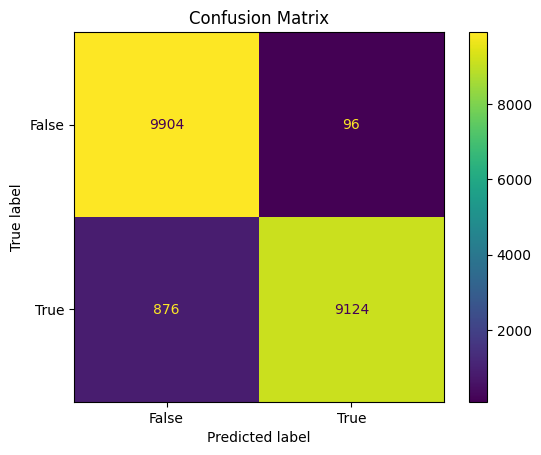

In [ ]:
cm = confusion_matrix(true_label, pred_label)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[False,True])
cm_display.plot()
plt.title('Confusion Matrix')
plt.savefig(os.path.join(save_path, "resnet/confusion matrix.png"))

## Inception Model

### Prepare Data

In [11]:
preprocess_func = inception_v3.preprocess_input
train_gen = customDataGen(train_path, preprocess_func)
val_gen = customDataGen(val_path, preprocess_func)
test_gen = customDataGen(test_path, preprocess_func, shuffle=False)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


### Build Model

In [12]:
inception_layer = inception_v3.InceptionV3(include_top = False, input_shape=image_shape)
inception_layer.trainable = False

87910968/87910968 [==============================] - 1s 0us/step


In [13]:
flatten = Flatten()(inception_layer.output)
output = Dense(1, activation='sigmoid', kernel_initializer='he_uniform')(flatten)
inception_model = Model(inputs=inception_layer.inputs, outputs=output)

inception_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
inception_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 127, 127, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 127, 127, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 127, 127, 32)         0         ['batch_normalization[0][0

### Train Model

In [14]:
history = inception_model.fit(train_gen, validation_data=val_gen, epochs=epochs)

Epoch 1/10
6250/6250 [==============================] - 439s 67ms/step - loss: 1.4056 - accuracy: 0.8027 - val_loss: 1.0742 - val_accuracy: 0.8551
Epoch 2/10
6250/6250 [==============================] - 417s 67ms/step - loss: 1.2043 - accuracy: 0.8594 - val_loss: 1.5234 - val_accuracy: 0.8426
Epoch 3/10
6250/6250 [==============================] - 400s 64ms/step - loss: 1.0451 - accuracy: 0.8818 - val_loss: 2.2003 - val_accuracy: 0.8220
Epoch 4/10
6250/6250 [==============================] - 421s 67ms/step - loss: 0.9703 - accuracy: 0.8934 - val_loss: 1.3123 - val_accuracy: 0.8758
Epoch 5/10
6250/6250 [==============================] - 422s 67ms/step - loss: 0.8906 - accuracy: 0.9041 - val_loss: 1.6697 - val_accuracy: 0.8638
Epoch 6/10
6250/6250 [==============================] - 399s 64ms/step - loss: 0.8112 - accuracy: 0.9108 - val_loss: 1.5788 - val_accuracy: 0.8754
Epoch 7/10
6250/6250 [==============================] - 397s 64ms/step - loss: 0.7816 - accuracy: 0.9166 - val_loss: 1

### Save Model

In [15]:
inception_model.save(os.path.join(save_path, "inception/inception_model.h5"))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Plots

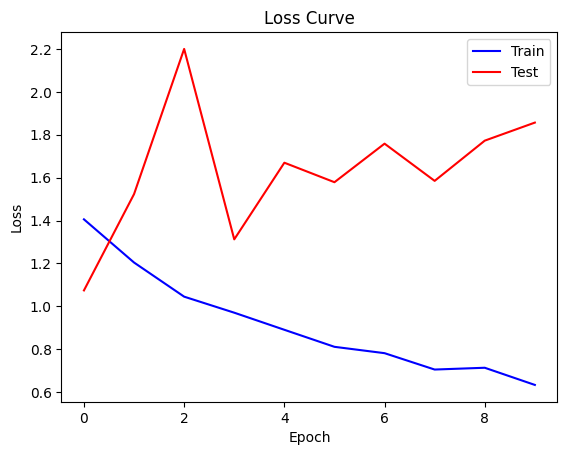

In [16]:
plt.plot(history.history['loss'], color='blue', label='Train')
plt.plot(history.history['val_loss'], color='red', label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.savefig(os.path.join(save_path, "inception/loss.png"))

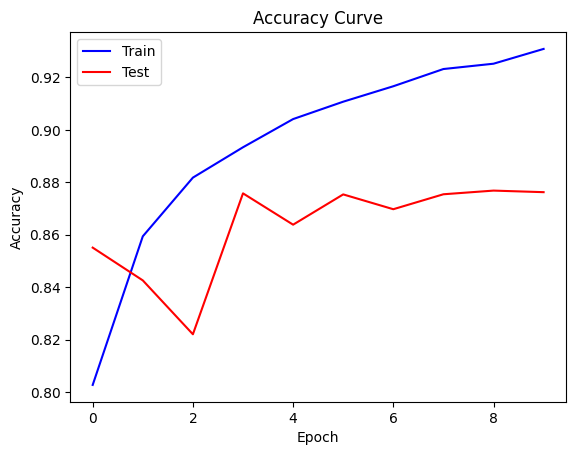

In [17]:
plt.plot(history.history['accuracy'], color='blue', label='Train')
plt.plot(history.history['val_accuracy'], color='red', label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.savefig(os.path.join(save_path, "inception/accuracy.png"))

### Evaluate Model

In [18]:
pred_value = inception_model.predict(test_gen).flatten()

1250/1250 [==============================] - 72s 55ms/step


In [19]:
pred_label = np.round(pred_value).astype(int)
true_label = test_gen.labels.flatten()

In [20]:
print('Accuracy =', accuracy_score(true_label, pred_label))
print('Precision =', precision_score(true_label, pred_label))
print('Recall =', recall_score(true_label, pred_label))

Accuracy = 0.87495
Precision = 0.9191727221911683
Recall = 0.8222


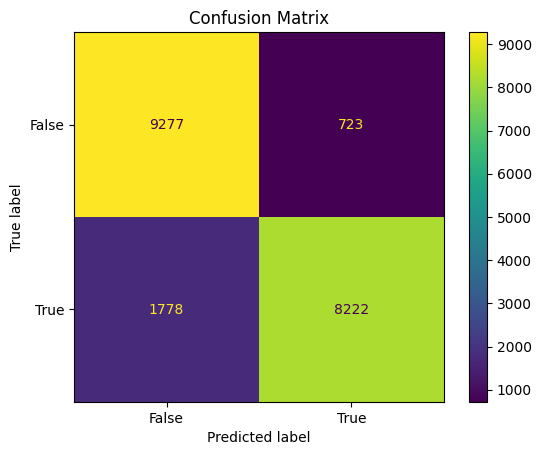

In [21]:
cm = confusion_matrix(true_label, pred_label)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[False,True])
cm_display.plot()
plt.title('Confusion Matrix')
plt.savefig(os.path.join(save_path, "inception/confusion matrix.png"))

## Custom Model

### Prepare Data

In [23]:
train_gen = customDataGen(train_path, rescale=1./255)
val_gen = customDataGen(val_path, rescale=1./255)
test_gen = customDataGen(test_path, rescale=1./255, shuffle=False)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


### Build Model

In [24]:
def Block(filters):
  block = [
    Conv2D(filters, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(),
    LeakyReLU(),
    Conv2D(filters, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform'),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(),
  ]
  return block

In [25]:
my_model = Sequential([
    Input(image_shape),

    *Block(8),
    *Block(8),

    *Block(16),
    *Block(16),

    *Block(32),
    *Block(32),

    Flatten(),
    Dense(1, activation='sigmoid', kernel_initializer='he_uniform')
])

my_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94 (Conv2D)          (None, 256, 256, 8)       224       
                                                                 
 batch_normalization_94 (Ba  (None, 256, 256, 8)       32        
 tchNormalization)                                               
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 8)       0         
                                                                 
 conv2d_95 (Conv2D)          (None, 256, 256, 8)       584       
                                                                 
 batch_normalization_95 (Ba  (None, 256, 256, 8)       32        
 tchNormalization)                                               
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256, 256, 8)       0

### Train Model

In [26]:
history = my_model.fit(train_gen, validation_data=val_gen, epochs=epochs)

Epoch 1/10
6250/6250 [==============================] - 363s 57ms/step - loss: 0.4074 - accuracy: 0.8090 - val_loss: 0.3290 - val_accuracy: 0.8605
Epoch 2/10
6250/6250 [==============================] - 311s 50ms/step - loss: 0.2119 - accuracy: 0.9135 - val_loss: 0.1824 - val_accuracy: 0.9270
Epoch 3/10
6250/6250 [==============================] - 313s 50ms/step - loss: 0.1509 - accuracy: 0.9399 - val_loss: 0.1508 - val_accuracy: 0.9398
Epoch 4/10
6250/6250 [==============================] - 318s 51ms/step - loss: 0.1173 - accuracy: 0.9542 - val_loss: 0.1557 - val_accuracy: 0.9391
Epoch 5/10
6250/6250 [==============================] - 317s 51ms/step - loss: 0.0973 - accuracy: 0.9631 - val_loss: 0.2032 - val_accuracy: 0.9257
Epoch 6/10
6250/6250 [==============================] - 317s 51ms/step - loss: 0.0822 - accuracy: 0.9688 - val_loss: 0.3176 - val_accuracy: 0.8908
Epoch 7/10
6250/6250 [==============================] - 316s 51ms/step - loss: 0.0723 - accuracy: 0.9726 - val_loss: 0

### Save Model

In [27]:
my_model.save(os.path.join(save_path, "custom/my_model.h5"))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Plots

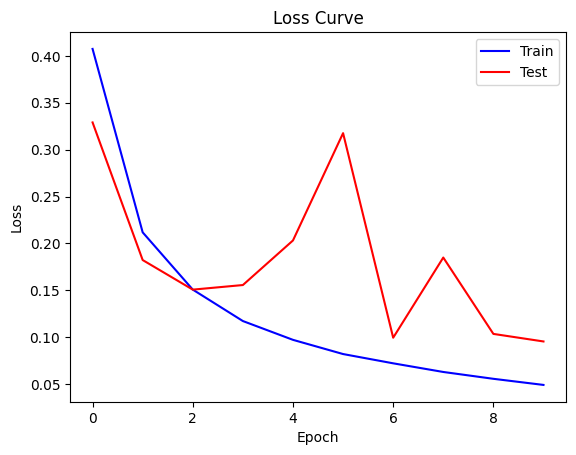

In [28]:
plt.plot(history.history['loss'], color='blue', label='Train')
plt.plot(history.history['val_loss'], color='red', label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.savefig(os.path.join(save_path, "custom/loss.png"))

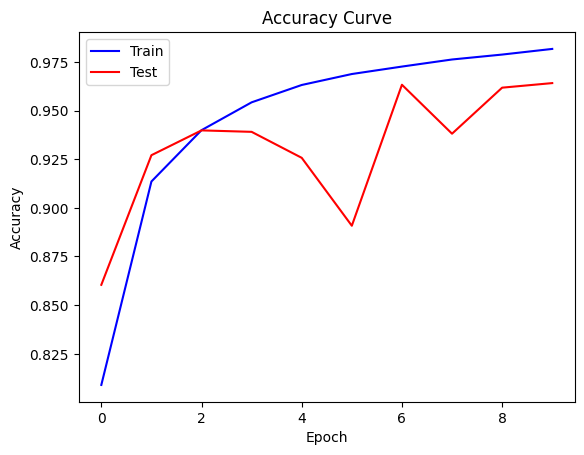

In [29]:
plt.plot(history.history['accuracy'], color='blue', label='Train')
plt.plot(history.history['val_accuracy'], color='red', label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.savefig(os.path.join(save_path, "custom/accuracy.png"))

### Evaluate Model

In [30]:
pred_value = my_model.predict(test_gen).flatten()

1250/1250 [==============================] - 47s 38ms/step


In [31]:
pred_label = np.round(pred_value).astype(int)
true_label = test_gen.labels.flatten()

In [32]:
print('Accuracy =', accuracy_score(true_label, pred_label))
print('Precision =', precision_score(true_label, pred_label))
print('Recall =', recall_score(true_label, pred_label))

Accuracy = 0.9659
Precision = 0.9718452501519141
Recall = 0.9596


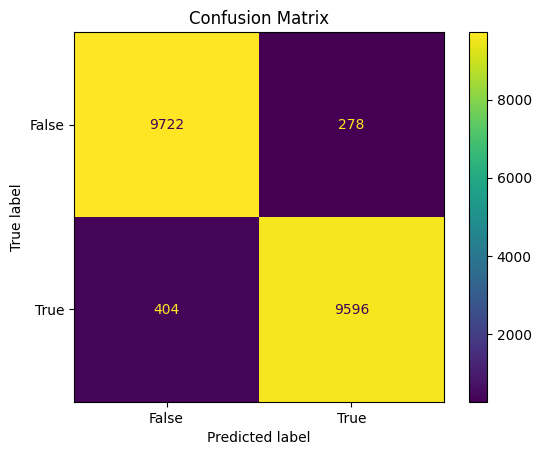

In [33]:
cm = confusion_matrix(true_label, pred_label)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[False,True])
cm_display.plot()
plt.title('Confusion Matrix')
plt.savefig(os.path.join(save_path, "custom/confusion matrix.png"))